#

# Imports and initial settings

In [1]:
import mysql.connector
import matplotlib.pyplot as plt
import requests
import json
import pandas as pd
import numpy as np
import re
import networkx as nx
import seaborn as sns
import netrd
import os
from scipy import stats
from sklearn.linear_model import LinearRegression
from itertools import *
from helper import *
from main import *
from matplotlib import colors

In [2]:
API_URL = "http://134.76.24.67/node" 
base = os.path.dirname(os.getcwd())

# Loading Data

### Participant Data

Dataframes of participant data from the visual construction and navigation tasks

trial_df <br>
silhouette_df <br>
session_df <br>
action_df <br>
navigation_df <br>
association_df <br>

In [3]:
# get trial info
r = requests.get(API_URL+"/trial")
#print("Status:",r.status_code)
pd_data = []
trials = json.loads(r.text)
for t in trials:
    record = [t["trial_id"], t["session_id"],t["silhouette_id"], t["time_stamp"], t["reward"], t["timeout"], t["experiment_part"],t["trial_type"]]
    pd_data.append(record)
 
trial_df = pd.DataFrame(pd_data, columns=['trial_id','session_id','silhouette_id', 'time_stamp', 'reward', 'timeout','experiment_part', 'trial_type'])

# get trial info
r = requests.get(API_URL+"/trial")
#print("Status:",r.status_code)
pd_data = []
trials = json.loads(r.text)
for t in trials:
    record = [t["trial_id"], t["session_id"],t["silhouette_id"], t["time_stamp"], t["reward"], t["timeout"], t["experiment_part"],t["trial_type"], t["silhouette"]]
    pd_data.append(record)
 
trial_df_w_silhouette = pd.DataFrame(pd_data, columns=['trial_id','session_id','silhouette_id', 'time_stamp', 'reward', 'timeout','experiment_part', 'trial_type', 'silhouette'])

# get silhouette info
r = requests.get(API_URL+"/silhouette")
#print("Status:", r.status_code)
pd_data = []
silhouettes = json.loads(r.text)
for s in silhouettes:
    record = [s["silhouette_id"], s["solution"], s["trial_type"]]
    pd_data.append(record)

silhouette_df = pd.DataFrame(pd_data, columns=["silhouette_id","solution","trial_type"])

# get session info
r = requests.get(API_URL+"/session")
#print("Status:",r.status_code)
pd_data = []
sessions = json.loads(r.text)
for s in sessions:
    # print(s)
    record = [s["session_id"], s["participant_id"], s["comment"]]
    pd_data.append(record)
    # print(s["comment"])

session_df = pd.DataFrame(pd_data, columns=['session_id', 'participant_id', 'comment'])

# get actions
r = requests.get(API_URL+"/action")
#print("Status:", r.status_code)
pd_data = []
actions = json.loads(r.text)
for a in actions:
    if a["building_block"] in [str(i) for i in range(9)]:
        record = [a["action_id"], a["trial"], int(a["building_block"]), a["reaction_time"], a["selected"]==1]
        pd_data.append(record)
#print("Found", len(pd_data), "actions")
    
action_df = pd.DataFrame(pd_data, columns=['action_id', 'trial_id', 'building_block', 'reaction_time', 'selected'])


# get navigation actions
r = requests.get(API_URL+"/navigation")
#print("Status:", r.status_code)
pd_data = []
navigation = json.loads(r.text)
for a in navigation:
  # print(a)
  record = [a["session_id"], a["stim_left"], a["stim_right"], a["solution"], a["selected"], a["trial"], a["show_length"]]
  pd_data.append(record)
    
navigation_df = pd.DataFrame(pd_data, columns=['session_id', 'stim_left', 'stim_right', 'solution', 'selected', 'trial', 'show_length'])

# get association data
r = requests.get(API_URL+"/association")
#print("Status:", r.status_code)
pd_data = []
association = json.loads(r.text)
for a in association:
  # print(a)
  record = [a["session_id"], a["trial"], a["building_block_id"], a["target"], a["pressed"], a["building_block_shown"], a["target_is_bb"]]
  pd_data.append(record)
    
association_df = pd.DataFrame(pd_data, columns=['session_id', 'trial', 'building_block_id', 'target', 'pressed', 'building_block_shown', 'target_is_bb'])


### Preprocessing of Participant Data

In [4]:
# Identify session ids of concern

session_ids = [1195,1197,1199,1203,1204,1210,1211,1214,1215,1223,1234,1236,1238,1239,1243,1244,1248,1249,1251,1258,1259] # sIDs

incorrect_prior = [1210,1211,1214,1215,1223]
correct_prior = [1195,1197,1199,1203,1204]
ids_diffG_Kath1 = [1234,1236,1238,1239,1243,1244] # adjacency_1
ids_diffG_Kath2 = [1248,1249,1251,1258,1259] # adjacency_2


In [5]:
# Selecting trial data of relevant session_ids

trial_sIDs = trial_df.query(f'session_id in {session_ids}').copy()
trial_sIDs_w_silhouette = trial_df_w_silhouette.query(f'session_id in {session_ids}').copy()
trial_sIDs_w_silhouette_rwd = trial_df_w_silhouette.query(f'session_id in {session_ids}').copy()
trial_sIDs_w_silhouette_rwd = trial_sIDs_w_silhouette_rwd[trial_sIDs_w_silhouette_rwd.reward == 1]

# Removing the string in the "silhouette_id" column of the dataframe: trial_sIDs

cleaned_sil_id_array = []

for i in np.arange(len(trial_sIDs)):
    text = trial_sIDs.iloc[i, 2] # the entry in the silhouette_id column, this is a string
    sil_id_str = re.split("_", text) # split the string at _, now I have a list of len 2
    sil_id =  int(sil_id_str[1]) # extracting relevant info; correspond to actual silhouette id, convert to int
    cleaned_sil_id_array.append(sil_id) # the append is ordered
    
# Now I have a list, I can just add this to a new column in the dataframe

trial_sIDs["silhouette_id"] = cleaned_sil_id_array # changing the silhouette id column

print(trial_sIDs.iloc[:,1].unique())

[1195 1197 1199 1203 1204 1210 1211 1214 1215 1223 1234 1236 1239 1238
 1243 1244 1248 1249 1251 1258 1259]


In [6]:
%%capture
# Selecting silhouettes with trial type 2

sils_trtype2 = silhouette_df[silhouette_df["trial_type"] == 2].sort_values(by=["silhouette_id"]) 

# multiple rows per silhouette_id need to check with Philipp, and be mindful when merging

sils_trtype2[sils_trtype2["silhouette_id"] == 0]

In [7]:
# Processing of the action dataframe for summed RTs

# Get trial_ids of the session_ids of concern

trial_id_sIDs = trial_sIDs['trial_id'] # get all relevant trial ids
trial_id_sIDs = np.array(trial_id_sIDs)

trial_id_sIDs_w_silhouette = trial_sIDs_w_silhouette['trial_id']
trial_id_sIDs_w_silhouette = np.array(trial_id_sIDs_w_silhouette)

# Selecting the action_df date for the relevant trial_ids/session_ids

action_sIDs = action_df[action_df['trial_id'].isin(trial_id_sIDs)]
action_sIDs_w_silhouette = action_df[action_df['trial_id'].isin(trial_id_sIDs_w_silhouette)]

# Slicing relevant columns in trial_df

action_sIDs_sliced = action_sIDs[["trial_id","reaction_time"]]
action_sIDs_sliced_w_silhouette = action_sIDs_w_silhouette[["trial_id","reaction_time"]]

# Grouped by trial_id, summing the reaction times
action_sIDs_grouped = action_sIDs_sliced.groupby("trial_id")
action_sIDs_summedRT = action_sIDs_grouped["reaction_time"].sum().to_frame(name="summed_rt").reset_index()

action_sIDs_grouped_w_silhouette = action_sIDs_sliced_w_silhouette.groupby("trial_id")
action_sIDs_summedRT_w_silhouette = action_sIDs_grouped_w_silhouette["reaction_time"].sum().to_frame(name="summed_rt").reset_index()

In [8]:
%%capture
# Merging trial_sIDs (trial data) and sils_trtype2 (silhouette data)

merged_sIDs = pd.merge(trial_sIDs,sils_trtype2, on='silhouette_id')
merged_sIDs[(merged_sIDs['silhouette_id'] == 0) & (merged_sIDs['session_id'] == 1195)]

In [9]:
# Merging merged_sIDs (trial + silhouette data) and action_sIDs_summedRT (summed RT data)

merged_sIDs_w_act = pd.merge(action_sIDs_summedRT, merged_sIDs, on='trial_id')
merged_sIDs_w_act_w_silhouette = pd.merge(action_sIDs_summedRT_w_silhouette, trial_sIDs_w_silhouette, on='trial_id')

## Filter those rewarded 
merged_sIDs_w_act_rwd = merged_sIDs_w_act[merged_sIDs_w_act.reward == 1]
merged_sIDs_w_act_w_silhouette_rwd = merged_sIDs_w_act_w_silhouette[merged_sIDs_w_act_w_silhouette.reward == 1]

In [10]:
%%capture
# Merging trial_sIDs_w_silhouette and action_df: this is for the per building block regression

merged_sIDs_w_act_sil_indi = pd.merge(trial_sIDs_w_silhouette,action_df, on='trial_id')
merged_sIDs_w_act_sil_indi = merged_sIDs_w_act_sil_indi[merged_sIDs_w_act_sil_indi.reward == 1] # filter those rewarded
merged_sIDs_w_act_sil_indi.sort_values(by=["action_id"])

In [11]:
# Filtering navigation data for relevant IDs

navigation_sIDs = navigation_df[navigation_df['session_id'].isin(session_ids)]

# Adding a column to identify correct trials

navigation_sIDs["correct"] = (navigation_sIDs["solution"] == navigation_sIDs["selected"])
navigation_sIDs = navigation_sIDs.astype({"correct": int})

# Separating the 4 groups 

CP_navigation_df = navigation_sIDs[navigation_sIDs['session_id'].isin(correct_prior)][["session_id","correct"]]
IP_navigation_df = navigation_sIDs[navigation_sIDs['session_id'].isin(incorrect_prior)][["session_id","correct"]]
adjacency_1_df = navigation_sIDs[navigation_sIDs['session_id'].isin(ids_diffG_Kath1)][["session_id","correct"]]
adjacency_2_df = navigation_sIDs[navigation_sIDs['session_id'].isin(ids_diffG_Kath2)][["session_id","correct"]]

# "correct prior"
CP_grouped_session_id = CP_navigation_df.groupby("session_id")
CP_scores = CP_grouped_session_id["correct"].sum().to_frame(name="sum correct").reset_index()

# "incorrect prior"
IP_grouped_session_id = IP_navigation_df.groupby("session_id")
IP_scores = IP_grouped_session_id["correct"].sum().to_frame(name="sum correct").reset_index()

# adjacency_1
adj_1_grouped_session_id = adjacency_1_df.groupby("session_id")
adj_1_scores = adj_1_grouped_session_id["correct"].sum().to_frame(name="sum correct").reset_index()

# adjacency_2
adj_2_grouped_session_id = adjacency_2_df.groupby("session_id")
adj_2_scores = adj_2_grouped_session_id["correct"].sum().to_frame(name="sum correct").reset_index()

# Preliminary means 
G_0_mean = CP_scores.loc[:,"sum correct"].mean()
G_4_mean = IP_scores.loc[:,"sum correct"].mean()

G_1_mean = adj_1_scores.loc[:,"sum correct"].mean()
G_2_mean = adj_2_scores.loc[:,"sum correct"].mean()

C:\Users\kmedriano\AppData\Local\Temp\ipykernel_24984\1159650479.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  navigation_sIDs["correct"] = (navigation_sIDs["solution"] == navigation_sIDs["selected"])


### Adjacency Data

In [12]:
# Loading the adjacencies

ground_truth = np.load(os.path.join(base,"tests","adjacency","ground_truth.npy")) # ground truth
opp = np.ones(ground_truth.shape)-ground_truth # "inverse" of the ground truth
np.fill_diagonal(opp, 0)

# Graph Similarity

### Generating adjacencies and graphs

In [13]:
# Generate other adjancencies

def adjacency_mat_generator():
    "Generate random adjacency matrix, symmetric with at least 4 elements with 1 as entry"

    adjacency = np.zeros((6,6))

    possible_edges = [1,2,3,4,5,8,9,10,11,15,16,17,22,23,29] # in the upper triangular
    edge_number = np.random.choice(np.arange(4,16),1) # we allow at least 4 edges                                              
    #edge_number = 5 # for generating adjacencies I will give to Philipp
    edges = np.random.choice(possible_edges, edge_number, replace=False) # without replacement
    edges = np.unravel_index(edges, (6,6))

    adjacency[edges] = 1
    adjacency = adjacency + adjacency.T # since should be symmetric

    return adjacency

### Adjacencies and graphs for the experiment

In [14]:
# Adjacencies I will give to Philipp

adjacency_1 = np.load(os.path.join(base,"tests","adjacency","adjacency_1.npy"))
# adjacency_2 = np.load(np.load(os.path.join(base,"tests","adjacency","adjacency_2.npy")))

# add_adj = [adjacency_1, adjacency_2]

graph_1 = nx.from_numpy_array(adjacency_1)
# graph_2 = nx.from_numpy_array(adjacency_2)

# Changed by Philipp

adjacency_2 = np.zeros((6,6))

adjacency_2[0,[1,4]] = 1
adjacency_2[1,[0,2,3]] = 1
adjacency_2[2,[1,3,5]] = 1
adjacency_2[3,[1,2]] = 1
adjacency_2[4,[0,5]] = 1
adjacency_2[5,[0,2,4]] = 1

# Adjacencies
adjacency_dict = {}
adjacency_dict['A_0'] = ground_truth
adjacency_dict['A_1'] = adjacency_1
adjacency_dict['A_2'] = adjacency_2
adjacency_dict["A_3"] = opp

# Graphs
graph_dict = {}

for i in np.arange(len(adjacency_dict.keys())): # 12 graphs
    graph_dict[f"G_{i}"] = nx.from_numpy_array(adjacency_dict[f"A_{i}"])


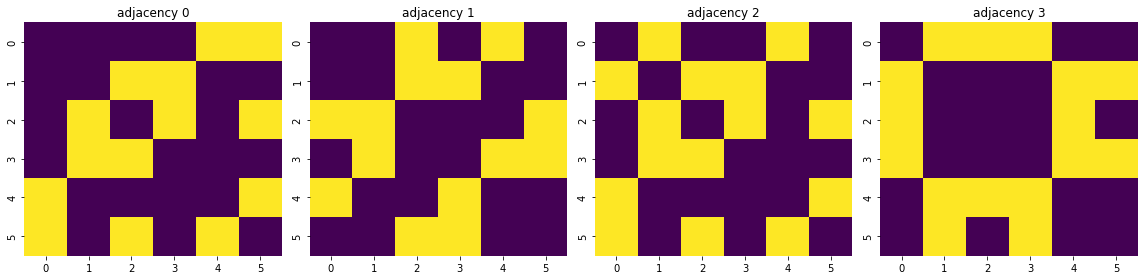

In [15]:
# Plot adjacency

fig,axn = plt.subplots(nrows=1, ncols=4, sharex=False, sharey=False, figsize=(16,4))

for i, ax in enumerate(axn.flat):
    sns.heatmap(adjacency_dict[f"A_{i}"], ax=ax,
                cmap='viridis',
                cbar=False
               # cbar=False else cbar=True
                )
    ax.set_title(f"adjacency {i}")

plt.tight_layout()


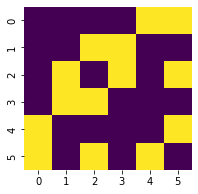

In [126]:
ax = plt.axes()

sns.heatmap(adjacency_dict["A_0"],
                cmap='viridis',
                cbar=False,
                #xticklabels=False, 
                #yticklabels=False
                )

plt.gcf().set_size_inches(3, 3)

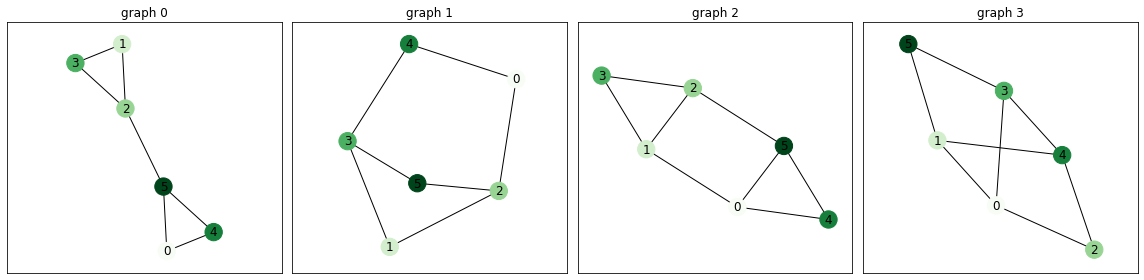

In [16]:
# Plot graph (4 for the experiment)

fig,axn = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True, figsize=(16,4))

for i, ax in enumerate(axn.flat):
    nx.draw_networkx(graph_dict[f"G_{i}"], node_color=range(6), cmap=plt.cm.Greens, ax=ax)
    ax.set_title(f"graph {i}")

plt.tight_layout()


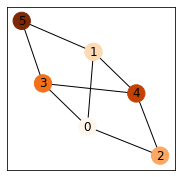

In [79]:
ax = plt.axes()

nx.draw_networkx(graph_dict["G_3"], node_color=range(6), cmap=plt.cm.Oranges)

plt.gcf().set_size_inches(3, 3)

In [17]:
%%capture
# Correlation for the 4 graphs used in the experiment

# Distance measures

dist_measures = [netrd.distance.Hamming(),
                netrd.distance.HammingIpsenMikhailov(),
                netrd.distance.NetSimile(),
                netrd.distance.DeltaCon()]

# Distance calculation

distances_exp_4 = np.zeros((len(graph_dict.keys()), len(dist_measures))) # will include the G_0 distance with itself

for i,graph_idx in enumerate(np.arange(distances_exp_4.shape[0])): # will include the G_0 distance with itself, that's why np.arange(0...) not np.arange(1)
    for j,measure in enumerate(dist_measures):
        dist = measure
        D = dist.dist(graph_dict["G_0"], graph_dict[f"G_{graph_idx}"])
        D = dist.results['dist']
        distances_exp_4[i,j] = D

graph = pd.Series([f"G_{i}" for i in np.arange(len(graph_dict.keys()))])
distances_exp_4_df = pd.DataFrame(distances_exp_4, columns = ['Hamming','HammingIpsenMikhailov','NetSimile','DeltaCon'])

distances_exp_4_df.insert(0, "Graph", graph)
distances_exp_4_df

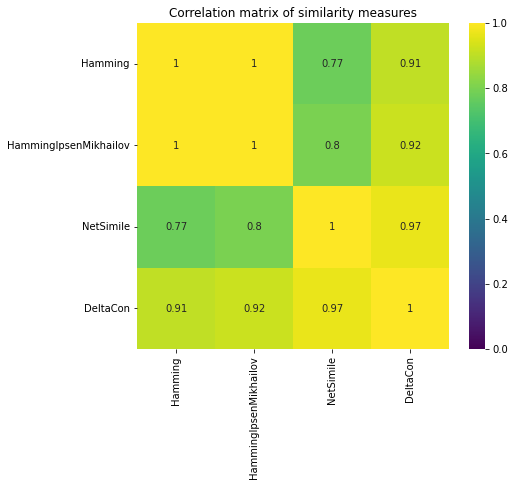

In [18]:
# Correlation among similarity measures (limited adjacencies)

ax = plt.axes()
sns.heatmap(distances_exp_4_df.corr(), cmap='viridis', annot=True, vmax=1, vmin=0, ax=ax)
ax.set_title('Correlation matrix of similarity measures')

plt.gcf().set_size_inches(7, 6)

In [19]:
# Including group mean performance
group_mean_4 = [G_0_mean,G_1_mean,G_2_mean,G_4_mean]

# sorted by DeltaCon ascending, 0 distance means more similar
distances_exp_4_df["group mean per graph"] = group_mean_4
distances_exp_4_df.sort_values(by=["DeltaCon"])

,Graph,Hamming,HammingIpsenMikhailov,NetSimile,DeltaCon,group mean per graph
0,G_0,0.000000,0.000000,0.000000,0.000000,46.400000
2,G_2,0.066667,0.074203,11.864973,0.663626,41.600000
1,G_1,0.400000,0.301266,13.493497,0.974654,24.333333
3,G_3,1.000000,0.710473,17.562755,1.469556,21.400000


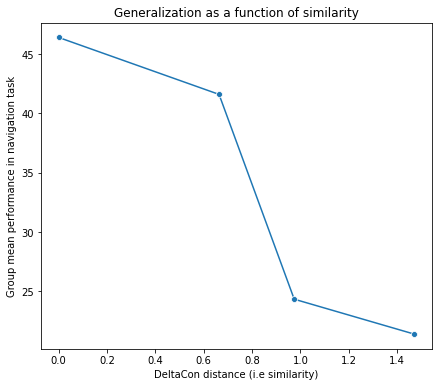

In [20]:
ax = plt.axes()

sns.lineplot(data=distances_exp_4_df, x="DeltaCon", y="group mean per graph", marker='o')

ax.set_title('Generalization as a function of similarity')
ax.set_xlabel('DeltaCon distance (i.e similarity)')
ax.set_ylabel('Group mean performance in navigation task')

plt.gcf().set_size_inches(7, 6)

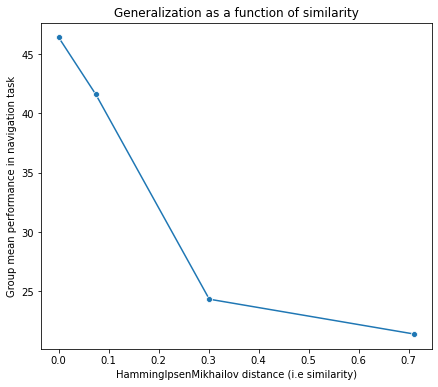

In [39]:
ax = plt.axes()

sns.lineplot(data=distances_exp_4_df, x="HammingIpsenMikhailov", y="group mean per graph", marker='o')

ax.set_title('Generalization as a function of similarity')
ax.set_xlabel('HammingIpsenMikhailov distance (i.e similarity)')
ax.set_ylabel('Group mean performance in navigation task')

plt.gcf().set_size_inches(7, 6)

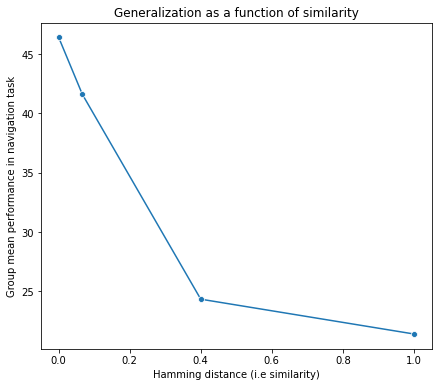

In [40]:
ax = plt.axes()

sns.lineplot(data=distances_exp_4_df, x="Hamming", y="group mean per graph", marker='o')

ax.set_title('Generalization as a function of similarity')
ax.set_xlabel('Hamming distance (i.e similarity)')
ax.set_ylabel('Group mean performance in navigation task')

plt.gcf().set_size_inches(7, 6)

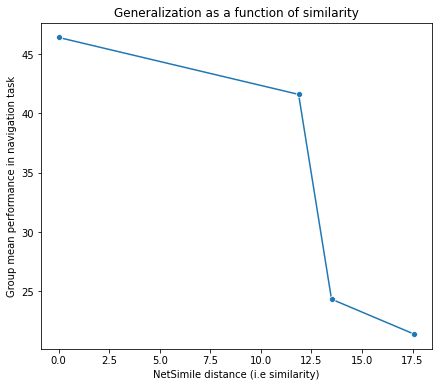

In [42]:
ax = plt.axes()

sns.lineplot(data=distances_exp_4_df, x="NetSimile", y="group mean per graph", marker='o')

ax.set_title('Generalization as a function of similarity')
ax.set_xlabel('NetSimile distance (i.e similarity)')
ax.set_ylabel('Group mean performance in navigation task')

plt.gcf().set_size_inches(7, 6)

### More detailed analysis

#### Learning rate 

In [21]:
# # Identify session ids of concern

# session_ids = [1195,1197,1199,1203,1204,1210,1211,1214,1215,1223,1234,1236,1238,1239,1243,1244,1248,1249,1251,1258,1259] # sIDs

# #correct_prior = [1195,1197,1199,1203,1204]
# correct_prior = [1197,1199,1203,1204]
# #ids_diffG_Kath2 = [1248,1249,1251,1258,1259]  # adjacency_2
# ids_diffG_Kath2 = [1248,1251,1258,1259]  # adjacency_2
# ids_diffG_Kath1 = [1234,1236,1238,1239,1243,1244] # adjacency_1
# incorrect_prior = [1210,1211,1214,1215,1223]
# #incorrect_prior = [1211,1214,1215,1223]

In [102]:
tang_perf_1 = np.append(tang_perf, [0,0,0,0])

In [105]:
tang_smoothed_rewards = np.convolve(tang_perf_1, np.ones((30,))/30, 'same')
nav_smoothed_rewards = np.convolve(nav_perf, np.ones((30,))/30, 'same')

In [106]:
tang_adj2[4,:] = tang_smoothed_rewards
nav_adj2[4,:] = nav_smoothed_rewards

In [137]:
## SLIDING WINDOW: LEARNING RATE INSTEAD OF CUMULATIVE

smoothing_window = 30

# tang_correct_prior = np.zeros((5,150))
# nav_correct_prior = np.zeros((5,102))

# tang_adj2 = np.zeros((5,150))
# nav_adj2 = np.zeros((5,102))

# tang_adj1 = np.zeros((6,150))
# nav_adj1 = np.zeros((6,102))

tang_incorrect_prior = np.zeros((5,150))
nav_incorrect_prior = np.zeros((5,102))

for idx, ses_id in enumerate(incorrect_prior):
    tang_perf = np.array(trial_df[trial_df["session_id"]==ses_id]["reward"])
    nav_perf = np.array(navigation_sIDs[navigation_sIDs["session_id"]==ses_id]["correct"])

    print(tang_perf.shape)
    print(nav_perf.shape)

    tang_smoothed_rewards = np.convolve(tang_perf, np.ones((smoothing_window,))/smoothing_window, 'same')
    nav_smoothed_rewards = np.convolve(nav_perf, np.ones((smoothing_window,))/smoothing_window, 'same')

    # tang_correct_prior[idx,:] = tang_smoothed_rewards
    # nav_correct_prior[idx,:] = nav_smoothed_rewards

    # tang_adj2[idx,:] = tang_smoothed_rewards
    # nav_adj2[idx,:] = nav_smoothed_rewards

    # tang_adj1[idx,:] = tang_smoothed_rewards
    # nav_adj1[idx,:] = nav_smoothed_rewards

    tang_incorrect_prior[idx,:] = tang_smoothed_rewards
    nav_incorrect_prior[idx,:] = nav_smoothed_rewards

(150,)
(102,)
(150,)
(102,)
(150,)
(102,)
(150,)
(102,)
(150,)
(102,)


In [138]:
# np.save(os.path.join(base,"tests","arrays","tang_correct_prior.npy"),tang_correct_prior)
# np.save(os.path.join(base,"tests","arrays","nav_correct_prior.npy"),nav_correct_prior)
# np.save(os.path.join(base,"tests","arrays","tang_adj2.npy"),tang_adj2)
# np.save(os.path.join(base,"tests","arrays","nav_adj2.npy"),nav_adj2)
# np.save(os.path.join(base,"tests","arrays","tang_adj1.npy"),tang_adj1)
# np.save(os.path.join(base,"tests","arrays","nav_adj1.npy"),nav_adj1)
np.save(os.path.join(base,"tests","arrays","tang_incorrect_prior.npy"),tang_incorrect_prior)
np.save(os.path.join(base,"tests","arrays","nav_incorrect_prior.npy"),nav_incorrect_prior)

In [139]:
tang_cp_mean = tang_correct_prior.mean(axis=0)
nav_cp_mean = nav_correct_prior.mean(axis=0)

tang_adj2_mean = tang_adj2.mean(axis=0)
nav_adj2_mean = nav_adj2.mean(axis=0)

tang_adj1_mean = tang_adj1.mean(axis=0)
nav_adj1_mean = nav_adj1.mean(axis=0)

tang_ip_mean = tang_incorrect_prior.mean(axis=0)
nav_ip_mean = nav_incorrect_prior.mean(axis=0)

In [140]:
tang_mean_df = pd.DataFrame(np.stack((tang_cp_mean,tang_adj2_mean,tang_adj1_mean,tang_ip_mean), axis=-1), columns=['G_0','G_2','G_1','G_3'])
nav_mean_df = pd.DataFrame(np.stack((nav_cp_mean,nav_adj2_mean,nav_adj1_mean,nav_ip_mean), axis=-1), columns=['G_0','G_2','G_1','G_3'])

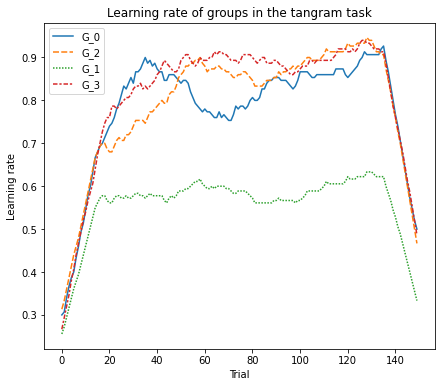

In [141]:
ax = plt.axes()

sns.lineplot(data=tang_mean_df)

ax.set_title('Learning rate of groups in the tangram task')
ax.set_xlabel('Trial')
ax.set_ylabel('Learning rate')

plt.gcf().set_size_inches(7, 6)

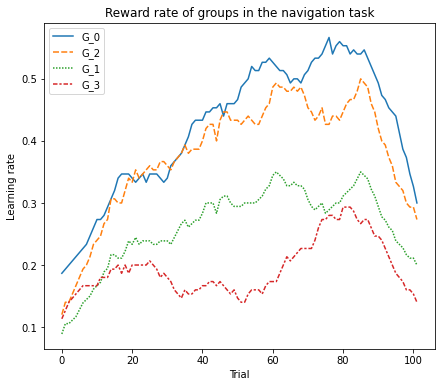

In [143]:
ax = plt.axes()

sns.lineplot(data=nav_mean_df)

ax.set_title('Reward rate of groups in the navigation task')
ax.set_xlabel('Trial')
ax.set_ylabel('Learning rate')

plt.gcf().set_size_inches(7, 6)

#### Cumulative reward scores

In [ ]:
slide = 1

fig = plt.figure(figsize=(12,24))

for idx, ses_id in enumerate(correct_prior):
    tang_perf = np.array(trial_sIDs_w_silhouette[trial_sIDs_w_silhouette.session_id==ses_id]["reward"])
    nav_perf = np.array(navigation_sIDs[navigation_sIDs.session_id==ses_id]["correct"])

    tang_trial_len = tang_perf.shape[0]    
    nav_trial_len = nav_perf.shape[0]

    tang_mov_sum = np.zeros(int(tang_trial_len/slide))
    x_tang = np.linspace(0,tang_trial_len,int(tang_trial_len/slide))

    nav_mov_sum = np.zeros(int(nav_trial_len/slide))
    x_nav = np.linspace(0,nav_trial_len,int(nav_trial_len/slide))

    for i in np.arange(len(tang_mov_sum)): # now I just assumed that tang_trial_len == nav_trial_len
        tang_mov_sum[i] = np.sum(tang_perf[:((i*slide)+slide)])

    for i in np.arange(len(nav_mov_sum)):
        nav_mov_sum[i] = np.sum(nav_perf[:((i*slide)+slide)])

    # Plot
    # Tangram

    ax = fig.add_subplot(5,2,((idx*2)+1))
    ax.plot(x_tang,tang_mov_sum, 'red')

    ax.set_title(f'session id: {ses_id}')
    ax.set_xlabel('trials')
    ax.set_ylabel('accuracy')
    ax.set_xlim([0, tang_trial_len])
    ax.set_ylim([0, tang_trial_len])

    # Nav
    ax2 = fig.add_subplot(5,2,((idx*2)+2))
    ax2.plot(x_nav,nav_mov_sum, 'blue')

    ax2.set_title(f'session id: {ses_id}')
    ax2.set_xlabel('trials')
    ax2.set_ylabel('accuracy')
    ax2.set_xlim([0, nav_trial_len])
    ax2.set_ylim([0, nav_trial_len])

plt.show()

In [ ]:
slide = 1

fig = plt.figure(figsize=(12,24))

for idx, ses_id in enumerate(ids_diffG_Kath2):
    tang_perf = np.array(trial_sIDs_w_silhouette[trial_sIDs_w_silhouette.session_id==ses_id]["reward"])
    nav_perf = np.array(navigation_sIDs[navigation_sIDs.session_id==ses_id]["correct"])

    tang_trial_len = tang_perf.shape[0]    
    nav_trial_len = nav_perf.shape[0]

    tang_mov_sum = np.zeros(int(tang_trial_len/slide))
    x_tang = np.linspace(0,tang_trial_len,int(tang_trial_len/slide))

    nav_mov_sum = np.zeros(int(nav_trial_len/slide))
    x_nav = np.linspace(0,nav_trial_len,int(nav_trial_len/slide))

    for i in np.arange(len(tang_mov_sum)): # now I just assumed that tang_trial_len == nav_trial_len
        tang_mov_sum[i] = np.sum(tang_perf[:((i*slide)+slide)])

    for i in np.arange(len(nav_mov_sum)):
        nav_mov_sum[i] = np.sum(nav_perf[:((i*slide)+slide)])

    # Plot
    # Tangram

    ax = fig.add_subplot(5,2,((idx*2)+1))
    ax.plot(x_tang,tang_mov_sum, 'red')

    ax.set_title(f'session id: {ses_id}')
    ax.set_xlabel('trials')
    ax.set_ylabel('accuracy')
    ax.set_xlim([0, tang_trial_len])
    ax.set_ylim([0, tang_trial_len])

    # Nav
    ax2 = fig.add_subplot(5,2,((idx*2)+2))
    ax2.plot(x_nav,nav_mov_sum, 'blue')

    ax2.set_title(f'session id: {ses_id}')
    ax2.set_xlabel('trials')
    ax2.set_ylabel('accuracy')
    ax2.set_xlim([0, nav_trial_len])
    ax2.set_ylim([0, nav_trial_len])

plt.show()

In [ ]:
# slide = 1

# fig = plt.figure(figsize=(12,24))

# for idx, ses_id in enumerate(ids_diffG_Kath1):
#     tang_perf = np.array(trial_sIDs_w_silhouette[trial_sIDs_w_silhouette.session_id==ses_id]["reward"])
#     nav_perf = np.array(navigation_sIDs[navigation_sIDs.session_id==ses_id]["correct"])

#     tang_trial_len = tang_perf.shape[0]    
#     nav_trial_len = nav_perf.shape[0]

#     tang_mov_sum = np.zeros(int(tang_trial_len/slide))
#     x_tang = np.linspace(0,tang_trial_len,int(tang_trial_len/slide))

#     nav_mov_sum = np.zeros(int(nav_trial_len/slide))
#     x_nav = np.linspace(0,nav_trial_len,int(nav_trial_len/slide))

#     for i in np.arange(len(tang_mov_sum)): # now I just assumed that tang_trial_len == nav_trial_len
#         tang_mov_sum[i] = np.sum(tang_perf[:((i*slide)+slide)])

#     for i in np.arange(len(nav_mov_sum)):
#         nav_mov_sum[i] = np.sum(nav_perf[:((i*slide)+slide)])

#     # Plot
#     # Tangram

#     ax = fig.add_subplot(5,2,((idx*2)+1))
#     ax.plot(x_tang,tang_mov_sum, 'red')

#     ax.set_title(f'session id: {ses_id}')
#     ax.set_xlabel('trials')
#     ax.set_ylabel('accuracy')
#     ax.set_xlim([0, tang_trial_len])
#     ax.set_ylim([0, tang_trial_len])

#     # Nav
#     ax2 = fig.add_subplot(5,2,((idx*2)+2))
#     ax2.plot(x_nav,nav_mov_sum, 'blue')

#     ax2.set_title(f'session id: {ses_id}')
#     ax2.set_xlabel('trials')
#     ax2.set_ylabel('accuracy')
#     ax2.set_xlim([0, nav_trial_len])
#     ax2.set_ylim([0, nav_trial_len])

# plt.show()

In [ ]:
slide = 1

fig = plt.figure(figsize=(12,24))

for idx, ses_id in enumerate(incorrect_prior):
    tang_perf = np.array(trial_sIDs_w_silhouette[trial_sIDs_w_silhouette.session_id==ses_id]["reward"])
    nav_perf = np.array(navigation_sIDs[navigation_sIDs.session_id==ses_id]["correct"])

    tang_trial_len = tang_perf.shape[0]    
    nav_trial_len = nav_perf.shape[0]

    tang_mov_sum = np.zeros(int(tang_trial_len/slide))
    x_tang = np.linspace(0,tang_trial_len,int(tang_trial_len/slide))

    nav_mov_sum = np.zeros(int(nav_trial_len/slide))
    x_nav = np.linspace(0,nav_trial_len,int(nav_trial_len/slide))

    for i in np.arange(len(tang_mov_sum)): # now I just assumed that tang_trial_len == nav_trial_len
        tang_mov_sum[i] = np.sum(tang_perf[:((i*slide)+slide)])

    for i in np.arange(len(nav_mov_sum)):
        nav_mov_sum[i] = np.sum(nav_perf[:((i*slide)+slide)])

    # Plot
    # Tangram

    ax = fig.add_subplot(5,2,((idx*2)+1))
    ax.plot(x_tang,tang_mov_sum, 'red')

    ax.set_title(f'session id: {ses_id}')
    ax.set_xlabel('trials')
    ax.set_ylabel('accuracy')
    ax.set_xlim([0, tang_trial_len])
    ax.set_ylim([0, tang_trial_len])

    # Nav
    ax2 = fig.add_subplot(5,2,((idx*2)+2))
    ax2.plot(x_nav,nav_mov_sum, 'blue')

    ax2.set_title(f'session id: {ses_id}')
    ax2.set_xlabel('trials')
    ax2.set_ylabel('accuracy')
    ax2.set_xlim([0, nav_trial_len])
    ax2.set_ylim([0, nav_trial_len])

plt.show()

# Model Fitting and Regression

### GLM per participant

Trial by trial prediction of RT

#### One regressor: summed log prob from connected model

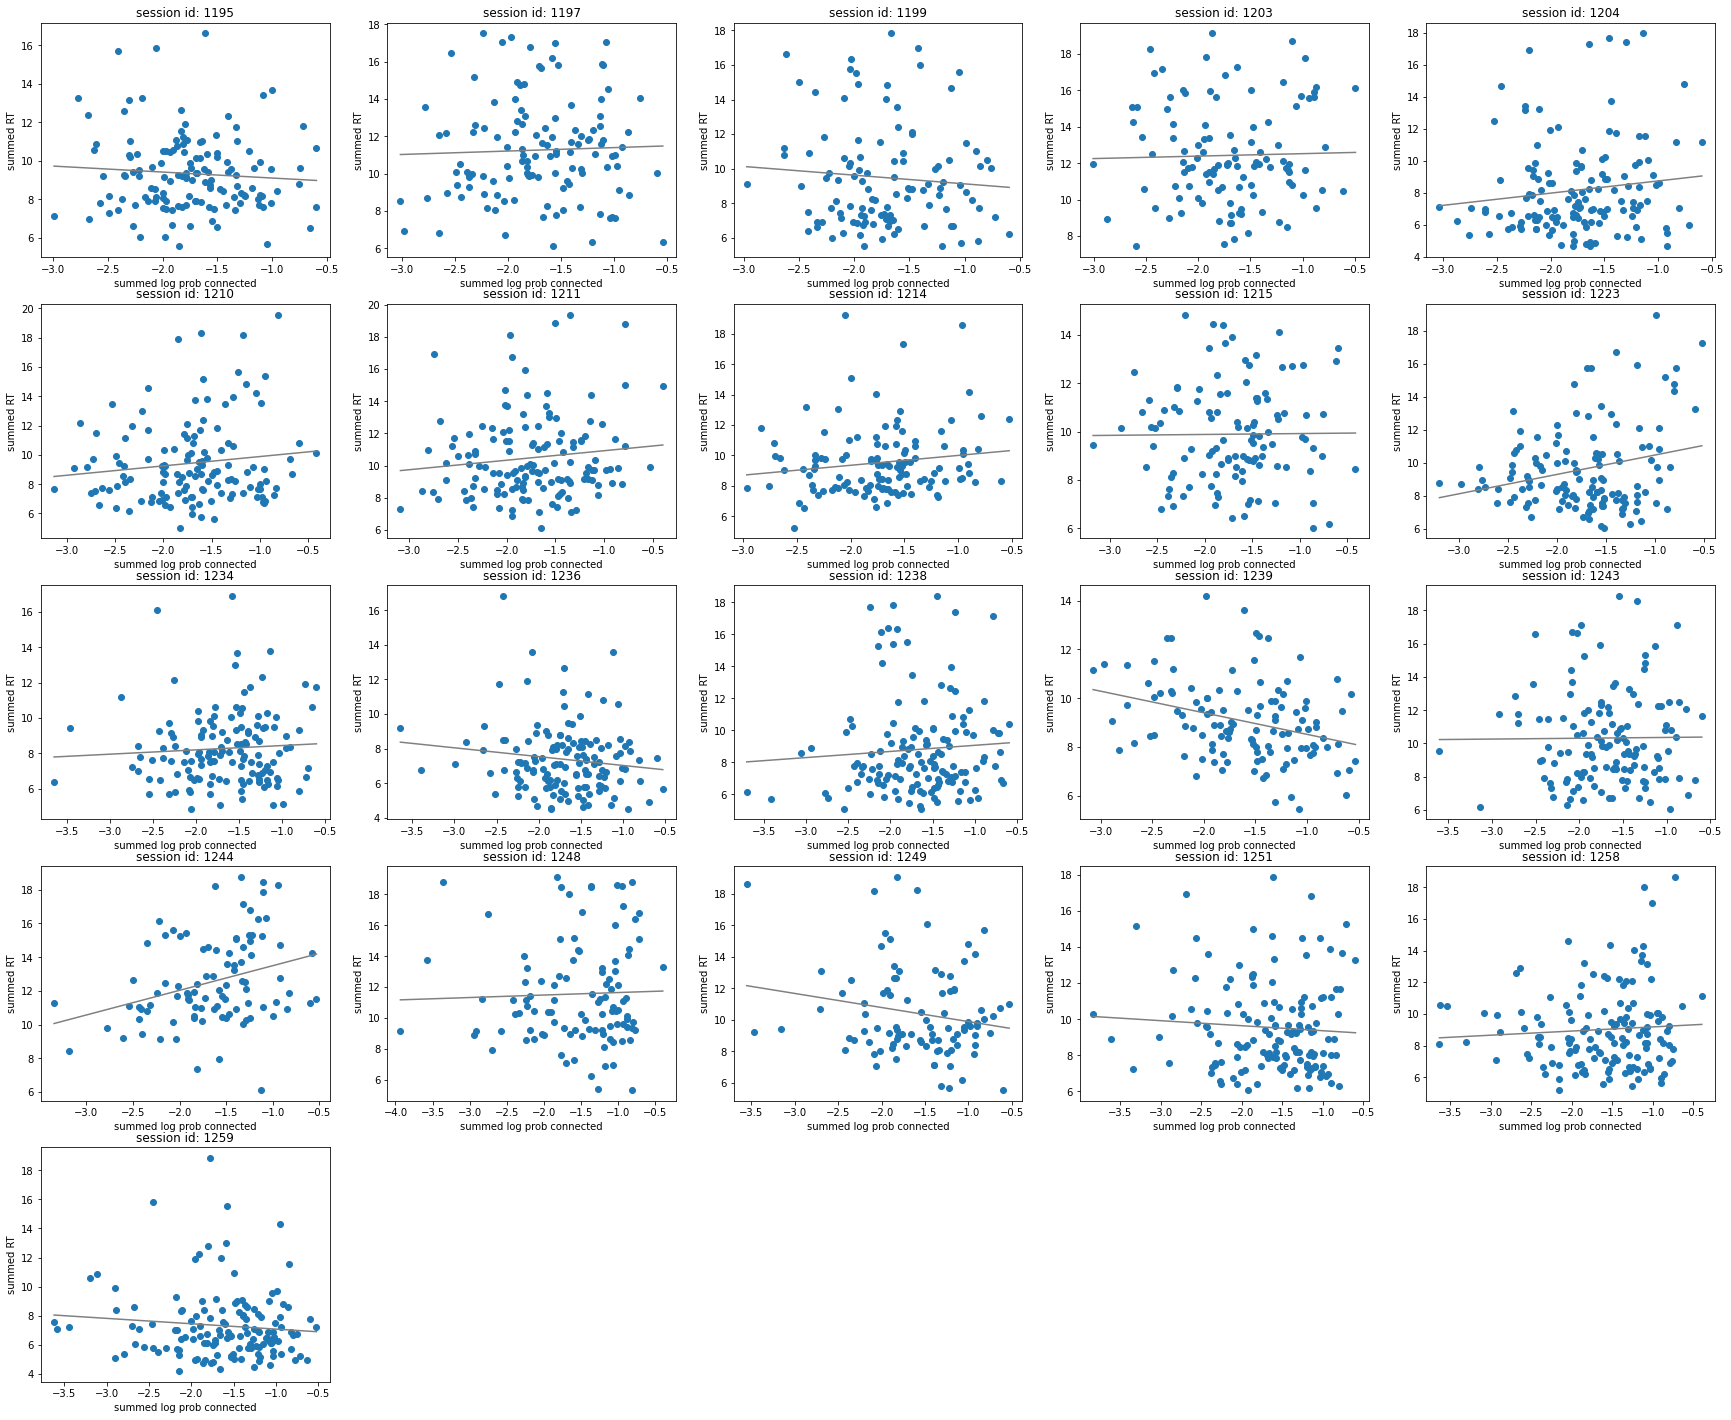

array([[ 1.19500000e+03, -3.10358309e-01,  8.78895238e+00],
       [ 1.19700000e+03,  1.84050710e-01,  1.15758975e+01],
       [ 1.19900000e+03, -5.02224193e-01,  8.61793194e+00],
       [ 1.20300000e+03,  1.34867159e-01,  1.26548059e+01],
       [ 1.20400000e+03,  7.63368236e-01,  9.50100277e+00],
       [ 1.21000000e+03,  6.36973311e-01,  1.05223461e+01],
       [ 1.21100000e+03,  5.89966773e-01,  1.15104541e+01],
       [ 1.21400000e+03,  6.48922752e-01,  1.06430326e+01],
       [ 1.21500000e+03,  3.67866868e-02,  9.95620743e+00],
       [ 1.22300000e+03,  1.17951973e+00,  1.16539043e+01],
       [ 1.23400000e+03,  2.43670501e-01,  8.68604526e+00],
       [ 1.23600000e+03, -5.10805670e-01,  6.51124794e+00],
       [ 1.23800000e+03,  3.83669778e-01,  9.45112305e+00],
       [ 1.23900000e+03, -8.84296338e-01,  7.63334545e+00],
       [ 1.24300000e+03,  4.92331368e-02,  1.04077816e+01],
       [ 1.24400000e+03,  1.46182280e+00,  1.49517484e+01],
       [ 1.24800000e+03,  1.60981031e-01

In [80]:
%%capture --no-display

# Per participant connected

indiv_param = [] # param holder

# For plotting
fig = plt.figure(figsize=[30,25])

for idx, k in enumerate(session_ids):

    session_id_data = merged_sIDs_w_act_w_silhouette_rwd[merged_sIDs_w_act_w_silhouette_rwd.session_id == k] # slice the relevant data for session_id
    solution_array = np.array(session_id_data["silhouette"]) 
    array_size = solution_array.shape[0]


    # run model per participant
    posterior_dict = connectivity_matmed(solution_array)

    # X: summed log probabilities from the learned adjacency matrix: posterior
    summed_log_prob = np.zeros(array_size)

    for sil in np.arange(array_size):

        elts = posterior_dict[str(sil)][0]*posterior_dict[str(sil)][1]
        log_elts = np.where(elts==0, elts, np.log(elts))
        summed_log_prob[sil] = np.divide(np.sum(log_elts),2)

    summed_log_prob = summed_log_prob.reshape(-1,1) # this summed log predicts similar value for each silhouette

    # RT: get it from session_id_data summed_rt column 

    summed_rt = np.array(session_id_data['summed_rt'])
    summed_rt = summed_rt.reshape(-1,1)

    # Regression

    reg = LinearRegression().fit(summed_log_prob,summed_rt) ####### ask if i need to do a "moving regression"??
    param = [k, reg.coef_[0][0], reg.intercept_[0]]

    indiv_param.append(param)
    
    # Plot
    ax = fig.add_subplot(5, 5, idx+1)

    # scatter
    rt = summed_rt
    regressor = summed_log_prob
    ax.scatter(summed_log_prob, rt)

    # plot surface/line
    min_regressor = min(summed_log_prob)
    max_regressor = max(summed_log_prob)

    regressor_lin = np.linspace(min_regressor, max_regressor, num=50) #co_occur
    rt_pred = reg.predict(regressor_lin)

    ax.plot(regressor_lin, rt_pred, 'gray')

    ax.set_title(f'session id: {k}')
    ax.set_xlabel('summed log prob connected')
    ax.set_ylabel('summed RT')

plt.show()
indiv_param = np.array(indiv_param)

indiv_param

In [81]:
# Coefficient check

coeffs_= indiv_param[:,1]

print(stats.ttest_1samp(coeffs_, 0))

Ttest_1sampResult(statistic=1.0558621585550503, pvalue=0.30361945803263835)


#### One regressor: log prob, instead of summed RT I'll use reaction times for individual building blocks (take choices 1,2,3 don't include first: 0)

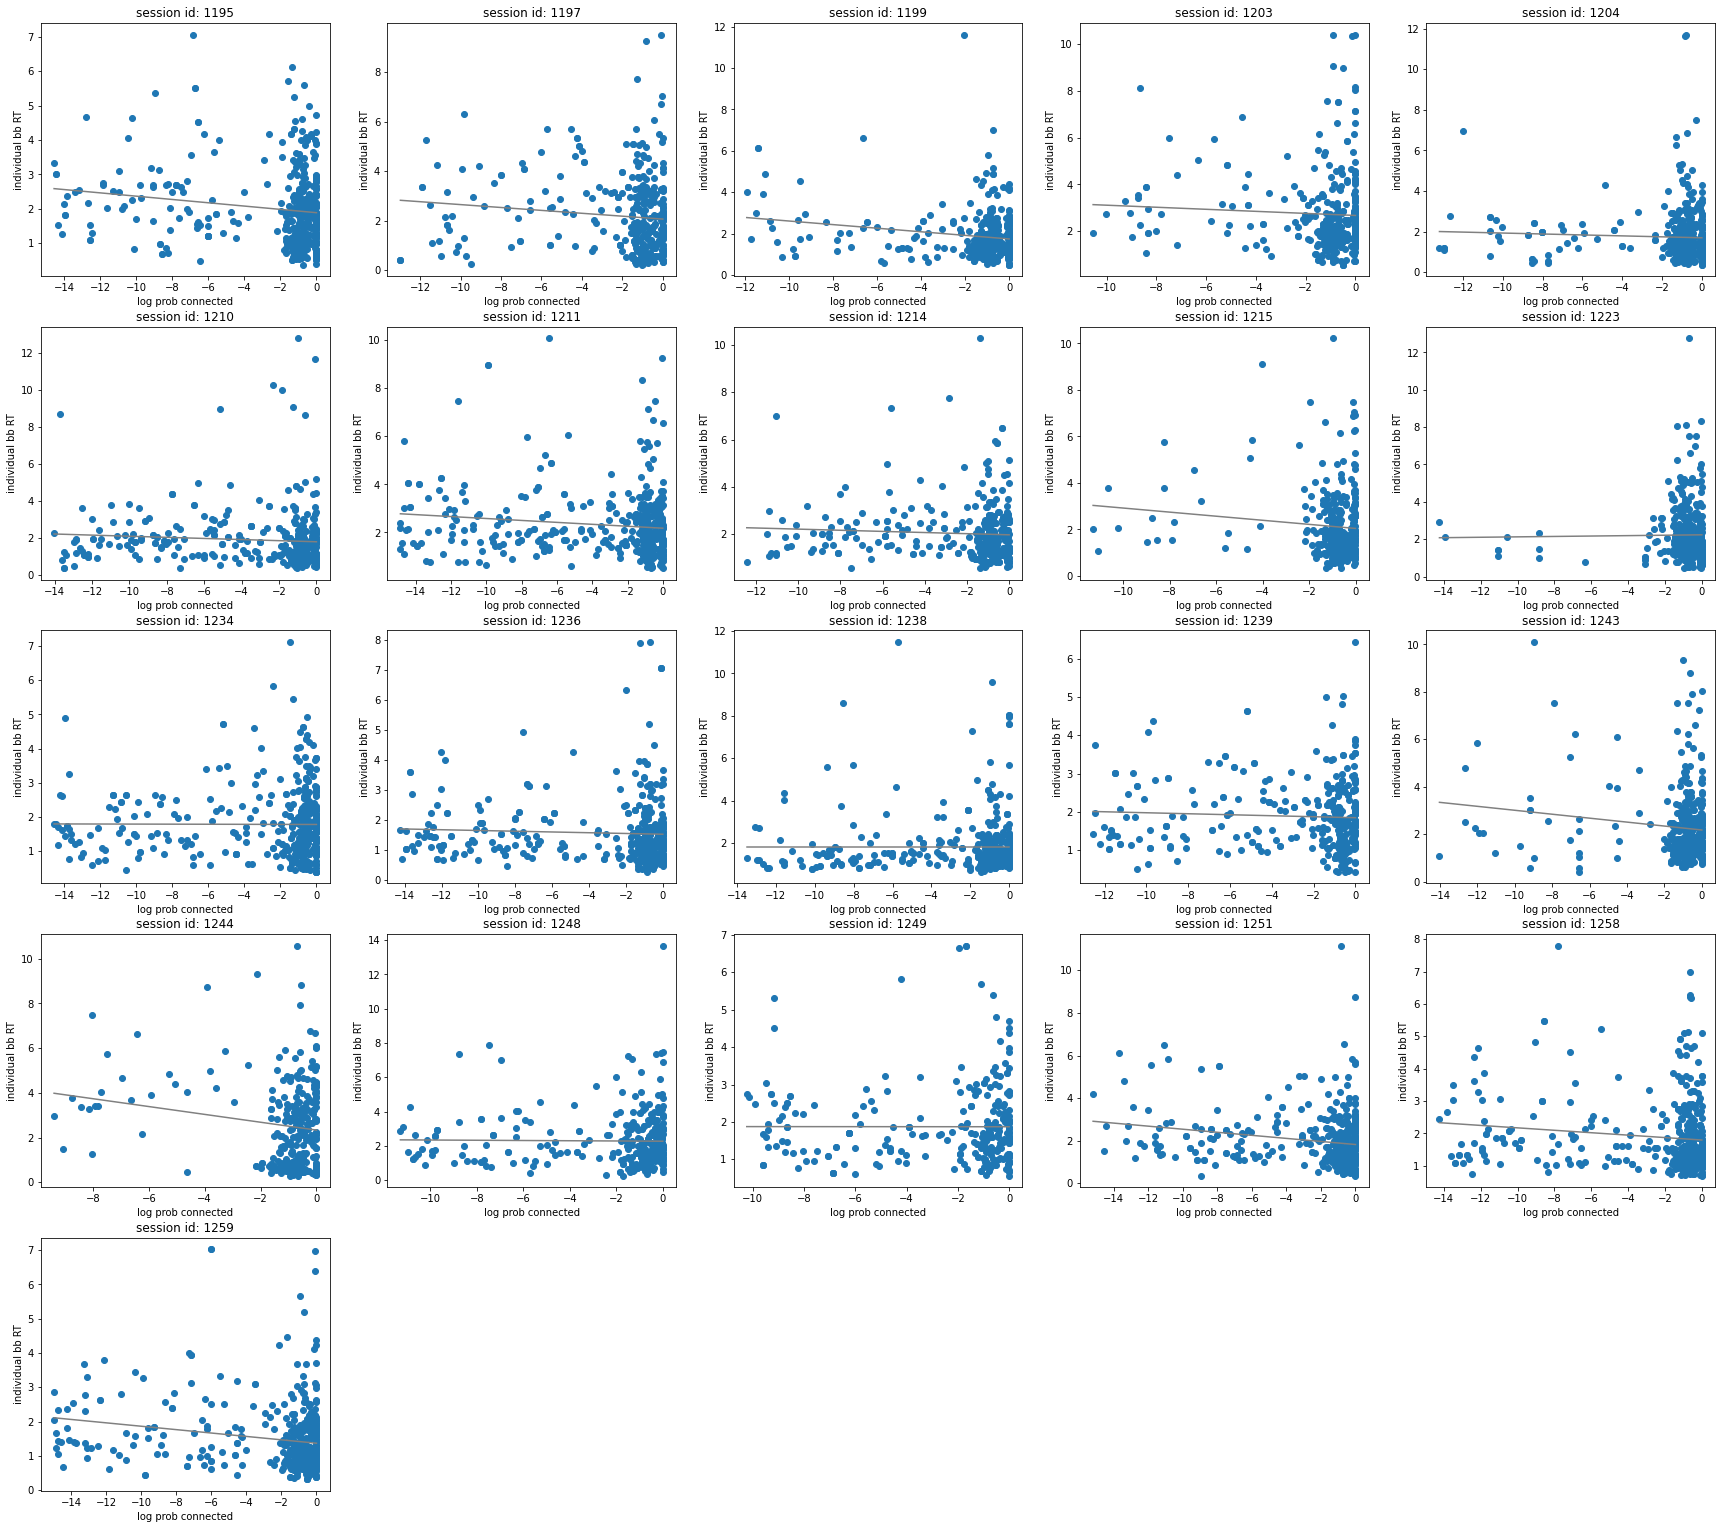

array([[ 1.19500000e+03, -4.79756309e-02,  1.89096900e+00],
       [ 1.19700000e+03, -5.84328255e-02,  2.06938617e+00],
       [ 1.19900000e+03, -8.66556347e-02,  1.74541564e+00],
       [ 1.20300000e+03, -4.37362785e-02,  2.67453626e+00],
       [ 1.20400000e+03, -2.33060162e-02,  1.69134752e+00],
       [ 1.21000000e+03, -2.99932047e-02,  1.79132723e+00],
       [ 1.21100000e+03, -4.03604644e-02,  2.17507289e+00],
       [ 1.21400000e+03, -2.40410801e-02,  1.96949624e+00],
       [ 1.21500000e+03, -8.77144839e-02,  2.04350408e+00],
       [ 1.22300000e+03,  1.09421891e-02,  2.23291440e+00],
       [ 1.23400000e+03, -1.08831120e-03,  1.77876159e+00],
       [ 1.23600000e+03, -1.24513497e-02,  1.52595758e+00],
       [ 1.23800000e+03, -1.29060094e-06,  1.81371857e+00],
       [ 1.23900000e+03, -1.29376854e-02,  1.84941629e+00],
       [ 1.24300000e+03, -8.32362854e-02,  2.17304805e+00],
       [ 1.24400000e+03, -1.75503154e-01,  2.33426503e+00],
       [ 1.24800000e+03, -7.01858094e-03

In [82]:
%%capture --no-display

# Per participant connected

indiv_param_indi = [] # param holder

# For plotting
fig = plt.figure(figsize=[30,27])

for k, ses_id in enumerate(session_ids): # this is per participant

    trial_id_array = np.array(trial_sIDs_w_silhouette_rwd[trial_sIDs_w_silhouette_rwd["session_id"]==ses_id]["trial_id"]) 
    silhouette_array = np.array(trial_sIDs_w_silhouette_rwd[trial_sIDs_w_silhouette_rwd["session_id"]==ses_id]["silhouette"])

    # run model per participant 
    posterior_dict = connectivity_matmed_key_sil(silhouette_array, trial_id_array, ses_id)

    log_array_indi = [] # X: individual log probabilities from the learned adjacency matrix: posterior
    rt_array_indi = [] # RT

    for trial_id in trial_id_array:
        action_id_array = np.array(action_df[action_df["trial_id"]==trial_id]["action_id"].sort_values())
        for idx, act_id in enumerate(action_id_array):
            #if idx % 4 != 0:
            if idx != 0:     
                bb_act_prev = action_df[action_df["action_id"]==act_id-1]["building_block"]
                bb_act = action_df[action_df["action_id"]==act_id]["building_block"]
                
                posterior_elt = posterior_dict[str(trial_id)][0][bb_act_prev,bb_act]
                if posterior_elt != 0:
                    log_indi = np.log(posterior_elt)
                    rt = action_df[action_df["action_id"]==act_id]["reaction_time"]

                log_array_indi.append(log_indi)
                rt_array_indi.append(rt)
            
    log_array = np.array(log_array_indi)
    log_array = log_array.reshape(-1,1)

    rt_array = np.array(rt_array_indi)
    rt_array = rt_array.reshape(-1,1)

    # Regression

    reg2 = LinearRegression().fit(log_array,rt_array) ####### ask if i need to do a "moving regression"??
    param = [ses_id, reg2.coef_[0][0], reg2.intercept_[0]]

    indiv_param_indi.append(param)
    
    # Plot
    ax = fig.add_subplot(5, 5, k+1)

    # scatter
    rt = rt_array
    regressor = log_array
    ax.scatter(log_array, rt_array)

    # plot surface/line
    min_regressor = min(log_array)
    max_regressor = max(log_array)

    regressor_lin = np.linspace(min_regressor, max_regressor, num=50) #connected
    rt_pred = reg2.predict(regressor_lin)

    ax.plot(regressor_lin, rt_pred, 'gray')

    ax.set_title(f'session id: {ses_id}')
    ax.set_xlabel('log prob connected')
    ax.set_ylabel('individual bb RT')

plt.show()
indiv_param_indi = np.array(indiv_param_indi)

indiv_param_indi

In [83]:
# Coefficient check

coeffs_= indiv_param_indi[:,1]

print(stats.ttest_1samp(coeffs_, 0))

Ttest_1sampResult(statistic=-4.502550724717748, pvalue=0.00021747507559338663)


In [129]:
ses_for_plot = [1197,1211,1238,1249]

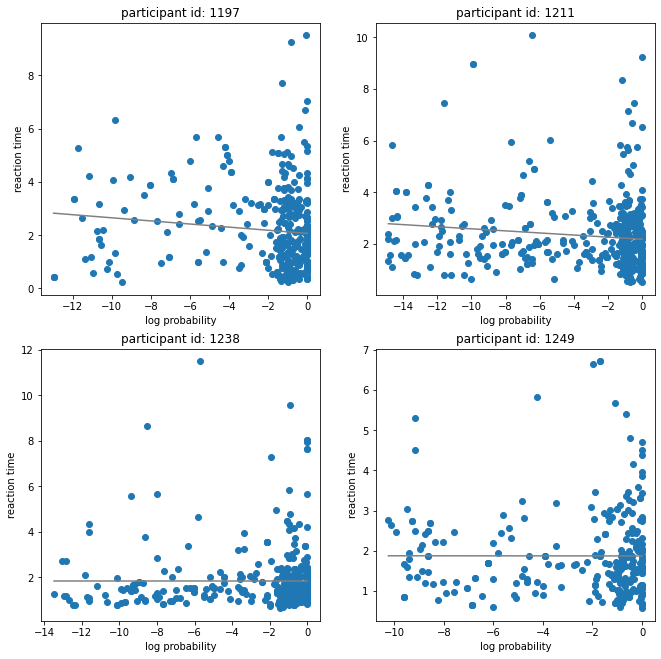

array([[ 1.19700000e+03, -5.84328255e-02,  2.06938617e+00],
       [ 1.21100000e+03, -4.03604644e-02,  2.17507289e+00],
       [ 1.23800000e+03, -1.29060094e-06,  1.81371857e+00],
       [ 1.24900000e+03, -3.94953060e-04,  1.87109917e+00]])

In [136]:
%%capture --no-display

# Per participant connected

indiv_param_indi = [] # param holder

# For plotting
fig = plt.figure(figsize=[11,11])

for k, ses_id in enumerate(ses_for_plot): # this is per participant

    trial_id_array = np.array(trial_sIDs_w_silhouette_rwd[trial_sIDs_w_silhouette_rwd["session_id"]==ses_id]["trial_id"]) 
    silhouette_array = np.array(trial_sIDs_w_silhouette_rwd[trial_sIDs_w_silhouette_rwd["session_id"]==ses_id]["silhouette"])

    # run model per participant 
    posterior_dict = connectivity_matmed_key_sil(silhouette_array, trial_id_array, ses_id)

    log_array_indi = [] # X: individual log probabilities from the learned adjacency matrix: posterior
    rt_array_indi = [] # RT

    for trial_id in trial_id_array:
        action_id_array = np.array(action_df[action_df["trial_id"]==trial_id]["action_id"].sort_values())
        for idx, act_id in enumerate(action_id_array):
            #if idx % 4 != 0:
            if idx != 0:     
                bb_act_prev = action_df[action_df["action_id"]==act_id-1]["building_block"]
                bb_act = action_df[action_df["action_id"]==act_id]["building_block"]
                
                posterior_elt = posterior_dict[str(trial_id)][0][bb_act_prev,bb_act]
                if posterior_elt != 0:
                    log_indi = np.log(posterior_elt)
                    rt = action_df[action_df["action_id"]==act_id]["reaction_time"]

                log_array_indi.append(log_indi)
                rt_array_indi.append(rt)
            
    log_array = np.array(log_array_indi)
    log_array = log_array.reshape(-1,1)

    rt_array = np.array(rt_array_indi)
    rt_array = rt_array.reshape(-1,1)

    # Regression

    reg2 = LinearRegression().fit(log_array,rt_array) ####### ask if i need to do a "moving regression"??
    param = [ses_id, reg2.coef_[0][0], reg2.intercept_[0]]

    indiv_param_indi.append(param)
    
    # Plot
    ax = fig.add_subplot(2, 2, k+1)

    # scatter
    rt = rt_array
    regressor = log_array
    ax.scatter(log_array, rt_array)

    # plot surface/line
    min_regressor = min(log_array)
    max_regressor = max(log_array)

    regressor_lin = np.linspace(min_regressor, max_regressor, num=50) #connected
    rt_pred = reg2.predict(regressor_lin)

    ax.plot(regressor_lin, rt_pred, 'gray')

    ax.set_title(f'participant id: {ses_id}')
    ax.set_xlabel('log probability')
    ax.set_ylabel('reaction time')

plt.show()
indiv_param_indi = np.array(indiv_param_indi)

indiv_param_indi

#### Two regressors: summed log prob, instead of summed RT, I'll use individual reaction times (take choices 1,2,3 don't include first:0) + ordering